#  Нейронные сети: Автокодировщик, Генеративно-Состязательные сети

## Библиотеки

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
import os
from urllib.request import urlopen
from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
from scipy.stats import norm
import torch

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Tensorboard

In [5]:
%load_ext tensorboard
%tensorboard --logdir ./

Launching TensorBoard...

## Код для обучени модели

In [6]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total
        

In [7]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

## Автокодировщик

In [8]:
digit_size = (28, 28)

### Код для обучения модели автокодировщика

In [9]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(model.device))
    
    loss = loss_function(output, x_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [10]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter = 100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size)
            
            pred = []
            real = []
            test_loss = 0
            model.eval()
            for it, (x_batch, _) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)

                output = model(x_batch)

                test_loss += self.loss_function(output, x_batch).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

            x = x_batch[-10:]
            
            fig = plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
            gs = gridspec.GridSpec(1, x.shape[0])
            for i in range(x.shape[0]):
                ax = fig.add_subplot(gs[i])
                ax.imshow(model(x.to(model.device)).cpu().data[i].view(*digit_size).numpy(), cmap='Greys_r', interpolation='lanczos')
                ax.axis('off')
                    
            self.writer.add_figure('VISUAL/decoded', fig, self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

### Линейный Автокодировщик

#### Данные

In [11]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor, 
                                 lambda x: x.view(784)])

In [12]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

In [13]:
for x_batch, y_batch in torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=64, shuffle=True):
    pass

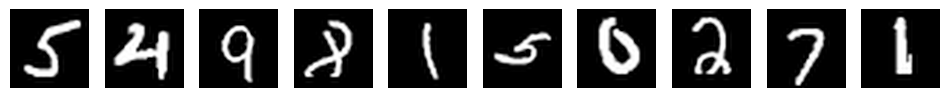

In [14]:
x = x_batch[-10:]
plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
for i in range(x.shape[0]):
    plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
    plt.imshow(x.data[i].view(*digit_size).numpy(), cmap='Greys_r', interpolation='lanczos')
    plt.axis('off')
        
plt.show()

#### Модель

In [15]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, object_dim, d):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.linear = torch.nn.Linear(object_dim, d)
        
    def forward(self, x):
        return self.linear(x)

In [16]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d, object_dim):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.linear = torch.nn.Linear(d, object_dim)
        
    def forward(self, x):
        return self.linear(x)

In [17]:
class Autoencoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, object_dim, d):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.encoder = Encoder(np.prod(digit_size), d)
        self.decoder = Decoder(d, np.prod(digit_size))
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

#### Определение модели

In [18]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam

#### Перебор разного d: обучение модели

In [19]:
for d in [2, 4, 8, 16, 32, 64]:
    autoencoder = Autoencoder(np.prod(digit_size), d)
    autoencoder.to(device)

    writer = SummaryWriter(log_dir = 'autoencoder-linear/{}'.format(d))

    call = callback(writer, MNIST_test, loss_function, delimeter = 100)

    trainer(count_of_epoch=5, 
            batch_size=64, 
            dataset=MNIST_train,
            model=autoencoder, 
            loss_function=loss_function,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

### Нейросетевой автокодировщик 

#### Данные

In [20]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor])

In [21]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

#### Модель

In [22]:
class EncoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d

        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(1, 6, kernel_size = 5))
        self.layers.add_module('bnorm1', torch.nn.BatchNorm2d(6))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))
        
        self.layers.add_module('conv2', torch.nn.Conv2d(6, 16, kernel_size = 5))
        self.layers.add_module('bnorm2', torch.nn.BatchNorm2d(16))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))
        
        self.layers.add_module('conv3', torch.nn.Conv2d(16, self.d, kernel_size = 3))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('pool3', torch.nn.MaxPool2d(kernel_size = 2))

        self.layers.add_module('flatten', torch.nn.Flatten())

    def forward(self, input):
        return self.layers(input)

In [23]:
class Reshape(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        return input.view(input.size(0), *self.dims)

In [24]:
class DecoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d

        self.layers = torch.nn.Sequential()
        self.layers.add_module('reshape1', Reshape(self.d, 1, 1))
        
        self.layers.add_module('conv1', torch.nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False))
        self.layers.add_module('bnorm1', torch.nn.BatchNorm2d(128))
        self.layers.add_module('relu1', torch.nn.ReLU())
        
        self.layers.add_module('conv2', torch.nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False))
        self.layers.add_module('bnorm2', torch.nn.BatchNorm2d(64))
        self.layers.add_module('relu2', torch.nn.ReLU())
        
        self.layers.add_module('conv3', torch.nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias=False))
        self.layers.add_module('bnorm3', torch.nn.BatchNorm2d(32))
        self.layers.add_module('relu3', torch.nn.ReLU())

        self.layers.add_module('conv4', torch.nn.ConvTranspose2d(32, 1, 4, 2, 1, 0, bias=False))
        self.layers.add_module('relu4', torch.nn.ReLU())
        
        self.layers.add_module('sigmoid', torch.nn.Sigmoid())
        
    def forward(self, x):
        return self.layers(x)

In [25]:
class AutoencoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d
        
        self.encoder = EncoderCNN(d)
        self.decoder = DecoderCNN(d)
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

#### Определение модели

In [26]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam

#### Перебор разного d: обучение модели

In [27]:
for d in [2, 4, 8, 16, 32, 64]:
    autoencoder = AutoencoderCNN(d)
    autoencoder.to(device)

    writer = SummaryWriter(log_dir = 'autoencoder-cnn/{}'.format(d))
    call = callback(writer, MNIST_test, loss_function, delimeter = 100)

    trainer(count_of_epoch=5, 
            batch_size=64, 
            dataset=MNIST_train,
            model=autoencoder, 
            loss_function=loss_function,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

### Вариационный автокодировщик

#### Модель

In [28]:
class VAE(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, latent_dim, input_dim, hidden_dim=200):
        """
        Standart model of VAE with ELBO optimization.
        Args:
            latent_dim: int - the dimension of latent space.
            input_dim: int - the dimension of input space.
            hidden_dim: int - the size of hidden_dim neural layer.
        Returns:
            None
        Example:
            >>> model = VAE(2, 10)
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.proposal_z = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, hidden_dim),
            torch.nn.LeakyReLU(),
        )
        self.proposal_mu = torch.nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_sigma = torch.nn.Linear(hidden_dim, self.latent_dim)

        self.generative_network = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, self.input_dim),
            torch.nn.Sigmoid()
        )

    def q_z(self, x):
        """
        Generates distribution of z provided x.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
            mu: Tensor - the matrix of shape batch_size x latent_dim.
            sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Example:
            >>>
        """
        x = x.to(self.device)

        proposal = self.proposal_z(x)
        mu = self.proposal_mu(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma(proposal))
        return mu, sigma

    def p_z(self, num_samples):
        """
        Generetes prior distribution of z.
        Args:
            num_samples: int - the number of samples.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape num_samples x latent_dim.
            	sigma: Tensor - the matrix of shape num_samples x latent_dim.
        Example:
            >>>
        """
        mu = torch.zeros([num_samples, self.latent_dim], device=self.device)
        sigma = torch.ones([num_samples, self.latent_dim], device=self.device)
        return mu, sigma

    def sample_z(self, distr, num_samples=1):
        """
        Generates samples from normal distribution q(z|x).
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            num_samples: int - the number of samples for each element.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x latent_dim - samples from normal distribution in latent space.
        Example:
            >>>
        """
        mu, sigma = distr
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        batch_size = mu.shape[0]

        bias = mu.view([batch_size, 1, self.latent_dim])

        epsilon = torch.randn([batch_size, num_samples, self.latent_dim],
                              requires_grad=True,
                              device=self.device)
        scale = sigma.view([batch_size, 1, self.latent_dim])

        return bias + epsilon * scale

    def q_x(self, z):
        """
        Given the latent representation matrix z, returns the matrix of Bernoulli distribution parameters for sampling x objects.
        Args:
            z: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples from latent space.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Example:
            >>>
        """
        z = z.to(self.device)
        out = self.generative_network(z)

        return torch.clamp(out, 0.01, 0.99)

    def loss(self, batch_x, batch_y):
        """
        Calculate ELBO approximation of log likelihood for given batch with negative sign.
        Args:
            batch_x: FloatTensor - the matrix of shape batch_size x input_dim.
            batch_y: FloatTensor - dont uses parameter in this model.
        Returns:
            Tensor - scalar, ELBO approximation of log likelihood for given batch with negative sign.
        Example:
            >>>
        """
        batch_x = batch_x.to(self.device)
        batch_y = batch_y.to(self.device)

        batch_size = batch_x.shape[0]

        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)

        x_distr = self.q_x(self.sample_z(propos_distr))

        expectation = torch.mean(
            self.log_mean_exp(
                self.log_likelihood(
                    batch_x, x_distr)), dim=0)

        divergence = self.divergence_KL_normal(propos_distr, pri_distr)

        return -1 * torch.mean(expectation - divergence, dim=0)

    def generate_samples(self, num_samples):
        """
        Generate samples of object x from noises in latent space.
        Args:
            num_samples: int - the number of samples, witch need to generate.
        Returns:
            Tensor - the matrix of shape num_samples x input_dim.
        Example:
            >>>
        """
        distr_z = self.p_z(num_samples=1)

        z = self.sample_z(distr, num_samples=num_samples)

        distr_x = self.q_x(z).view([num_samples, -1])

        return torch.bernoulli(distr_x, device=self.device)

    @staticmethod
    def log_pdf_normal(distr, samples):
        """
        The function calculates the logarithm of the probability density at a point relative to the corresponding normal distribution given componentwise by its mean and standard deviation.
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            samples: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples in latent space.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples, each element of which is the logarithm of the probability density of a point relative to the corresponding distribution.
        Example:
            >>>
        """
        mu, sigma = distr

        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]

        f1 = torch.sum(((samples -
                         mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3

    @staticmethod
    def log_likelihood(x_true, x_distr):
        """
        Calculate log likelihood between x_true and x_distr.
        Args:
            x_true:  Tensor - the matrix of shape batch_size x input_dim.
            x_distr: Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples - log likelihood for each sample.
        Example:
            >>>
        """
        batch_size = x_distr.shape[0]
        input_dim = x_distr.shape[2]

        bernoulli_log_likelihood = torch.log(
            x_distr) * x_true.view([batch_size, 1, input_dim])
        bernoulli_log_likelihood += torch.log(1 - x_distr) * (
            1 - x_true).view([batch_size, 1, input_dim])

        return torch.sum(bernoulli_log_likelihood, dim=2)

    @staticmethod
    def log_mean_exp(data):
        """
        Args:
            data: Tensor - the tensor of shape n_1 x n_2 x ... x n_K.
        Returns:
            Tensor - the tensor of shape n_1 x n_2 x ,,, x n_{K - 1}.
        Example:
            >>>
        """

        return torch.logsumexp(data, dim=-1) - \
            torch.log(torch.Tensor([data.shape[-1]]).to(data.device))

    @staticmethod
    def divergence_KL_normal(q_distr, p_distr):
        """
        Calculate KL-divergence KL(q||p) between n-pairs of normal distribution.
        Args:
            q_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            p_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Returns:
            Tensor - the vector of shape n, each value of which is a KL-divergence between pair of normal distribution.
        Example:
            >>>
        """
        q_mu, q_sigma = q_distr
        p_mu, p_sigma = p_distr

        D_KL = torch.sum((q_sigma / p_sigma)**2, dim=1)
        D_KL -= p_mu.shape[1]
        D_KL += 2 * torch.sum(torch.log(p_sigma), dim=1) - \
            2 * torch.sum(torch.log(q_sigma), dim=1)
        D_KL += torch.sum((p_mu - q_mu) * (p_mu - q_mu) / (p_sigma**2), dim=1)
        return 0.5 * D_KL

    def forward(self, x):
      """
        Generate decoded sample after encoding.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            Tensor - the matrix of shape batch_size x input_dim.
        Example:
            >>>
        """
      return self.q_x(self.sample_z(self.q_z(x))).view_as(x)


#### Скрипты для обучение VAE

In [29]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    loss = model.loss(x_batch.to(model.device), y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

#### Данные

In [30]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor, 
                                 lambda x: x.view(784)])

In [31]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

#### Инициализация модели

In [32]:
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()

#### Перебор разного размера латентного пространства

In [33]:
for d in [64, 32, 16, 8, 4, 2]:
    autoencoder = VAE(d, 28*28)
    autoencoder.to(device)

    writer = SummaryWriter(log_dir = 'autoencoder-vae/{}'.format(d))
    call = callback(writer, MNIST_test, loss_function, delimeter = 100)

    trainer(count_of_epoch=10, 
            batch_size=64, 
            dataset=MNIST_train,
            model=autoencoder, 
            loss_function=None,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

#### Отрисовка изменения (возмущаем скрытые вектора)

In [34]:
def draw_samples_grid_vae(model,
                          num_row=15,
                          num_colum=15,
                          images_size=(28, 28)):
    """
    Illustrate how change digits x where change point in latent space z.
    Args:
        model: nn.Module - model VAE or IWAE.
        num_row: int - the number of row.
        num_colum: int - the number of column.
        images_size = (x_size, y_size): tuple(int, int) - a size of input image.
    Returns:
        figure: float - the picture
    Example:
        >>>
    """
    grid_x = norm.ppf(np.linspace(0.05, 0.95, num_colum))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, num_row))

    figure = np.zeros((images_size[0] * num_colum, images_size[1] * num_row))
    for i, y_i in enumerate(grid_x):
        for j, x_i in enumerate(grid_y):
            z_sample = np.array([[x_i, y_i]])

            x_sample = model.q_x(torch.from_numpy(z_sample).float()).view(
                images_size).cpu().data.numpy()

            image = x_sample
            figure[i * images_size[0]: (i + 1) * images_size[0],
                   j * images_size[1]: (j + 1) * images_size[1]] = image

    return figure

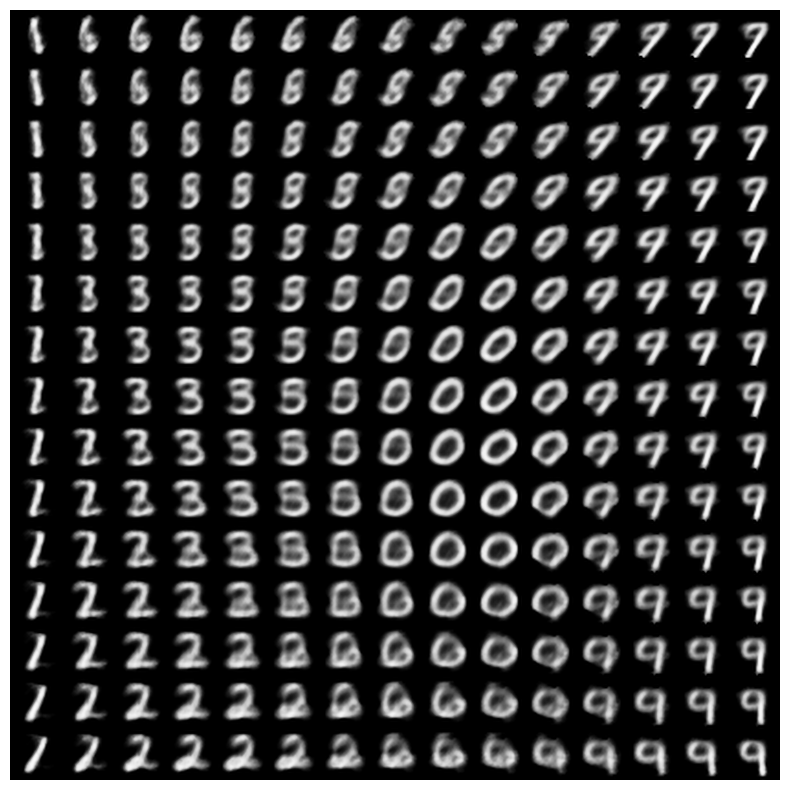

In [35]:
figure = draw_samples_grid_vae(autoencoder)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

## Transfer Learning

### Предобученые модели

#### Загрузим данные котиков и собачек

In [56]:
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -qq cats_and_dogs_filtered.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [57]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

CatDogs_train = datasets.ImageFolder(root = 'cats_and_dogs_filtered/train/', 
                                     transform = preprocess)
CatDogs_test = datasets.ImageFolder(root = 'cats_and_dogs_filtered/validation/', 
                                     transform = preprocess)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'cats_and_dogs_filtered/train/'

#### Загрузим предобученую модель

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True, verbose=False)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
model.to(device)

#### Скрипты для обучения

In [ ]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(device))
    
    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [ ]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter = 100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size, 
                                                          pin_memory=True)
            
            pred = []
            real = []
            test_loss = 0
            model.eval()
            for it, (x_batch, y_batch) in enumerate(batch_generator):
                x_batch = x_batch.to(device)

                output = model(x_batch)

                test_loss += self.loss_function(output, y_batch.to(device)).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
                real.extend(y_batch.cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
            self.writer.add_text('REPORT/test', str(classification_report(real, pred)), self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

#### Инициализация модели

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

#### Качество до дообучения

In [ ]:
real = []
pred = []
for x_batch, y_batch in torch.utils.data.DataLoader(CatDogs_test, 
                                                    batch_size = 64, 
                                                    shuffle = True, 
                                                    pin_memory=True):
  
    with torch.no_grad():
        output = model(x_batch.to(device))
    pred.extend(output.argmax(dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

print(classification_report(real, pred))

#### Обучение модели

In [ ]:
writer = SummaryWriter(log_dir = 'transfer-resnet18')
call = callback(writer, CatDogs_test, loss_function, delimeter = 10)

trainer(count_of_epoch=10, 
        batch_size=64, 
        dataset=CatDogs_train,
        model=model,
        loss_function=loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)

#### Качество после дообучения

In [ ]:
real = []
pred = []
for x_batch, y_batch in torch.utils.data.DataLoader(CatDogs_test, 
                                                    batch_size = 64, 
                                                    shuffle = True, 
                                                    pin_memory=True):
  
    with torch.no_grad():
        output = model(x_batch.to(device))
    pred.extend(output.argmax(dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

print(classification_report(real, pred))

## Генеративно состязательные сети

### GAN's для MNIST

#### Полезный код для обучения

In [36]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    optima_generator, optima_discriminator = optimizer
    
    optima_generator.zero_grad()
    optima_discriminator.zero_grad()
    discriminator_loss = model.discriminator_loss(x_batch)
    discriminator_loss.backward()
    optima_discriminator.step()

    optima_generator.zero_grad()
    optima_discriminator.zero_grad()
    generator_loss = model.generator_loss(len(x_batch))
    generator_loss.backward()
    optima_generator.step()
    
    return discriminator_loss.cpu().item()+generator_loss.cpu().item()

In [37]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(model.device), batch_of_y.to(model.device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [38]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima_generator = optimizer(model.generator.parameters(), lr=lr*10, betas=(0.5, 0.999))
    optima_discriminator = optimizer(model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'epoch loss': np.nan})
    for it in iterations:        
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(
            train_generator=batch_generator, 
            model=model, 
            loss_function=loss_function, 
            optimizer=(optima_generator, optima_discriminator), 
            callback=callback)
        
        iterations.set_postfix({'epoch loss': epoch_loss})

#### Модель нейросети

In [39]:
class Reshape(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        return input.view(input.size(0), *self.dims)

class GAN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d, D):
        super(type(self), self).__init__()
        self.d = d
        self.discriminator = torch.nn.Sequential(
            Reshape(1, D, D),
            torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.LeakyReLU(negative_slope=0.2),
            Reshape(-1),
            torch.nn.Linear(in_features=256, out_features=1),
            torch.nn.Sigmoid()
        )
        self.generator = torch.nn.Sequential(
            Reshape(self.d, 1, 1),
            torch.nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, 4, 2, 1, 0, bias=False),
            Reshape(-1),
            torch.nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        return torch.randn([num_samples, self.d], requires_grad=True).to(self.device)

    def generate_samples(self, num_samples):
        return self.generator(self.generate_noise(num_samples))

    def discriminator_loss(self, batch):
        loss = torch.nn.BCELoss()
        
        batch_size = batch.shape[0]
        
        fake_batch = self.discriminator(self.generate_samples(batch_size).detach())
        real_batch = self.discriminator(batch)
        
        fake_answ = torch.zeros(batch_size, 1).to(self.device)
        real_answ = torch.ones(batch.shape[0], 1).to(self.device)
        
        return 0.5*loss(fake_batch, fake_answ) + 0.5*loss(real_batch, real_answ)

    def generator_loss(self, batch_size):
        loss = torch.nn.BCELoss()
        
        fake_batch = self.discriminator(self.generate_samples(batch_size))
        
        real_answ = torch.ones(batch_size, 1).to(self.device)
            
        return loss(fake_batch, real_answ)
    
    def init_weight(self, mean, std):
        for m in self._modules:
            if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
                self._modules[m].weight.data.normal_(mean, std)
                self._modules[m].bias.data.zero_()


#### Инициализация модели

In [40]:
loss_function = None
optimizer = torch.optim.Adam

model = GAN(2, 28)
model.to(device)

GAN(
  (discriminator): Sequential(
    (0): Reshape()
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Reshape()
    (11): Linear(in_features=256, out_features=1, bias=True)
    (12): Sigmoid()
  )
  (generator): Sequential(
    (0): Reshape()
    (1): ConvTranspose2d(2, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReL

#### Выборка

In [41]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

#### Вспомагательные функции

In [42]:
def show_images(x, digit_size=28):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', interpolation='lanczos')
        plt.axis('off')

In [43]:
def generate_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(
            model.generate_samples(
                min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0).cpu().detach()

#### Как генерируются данные до обучения

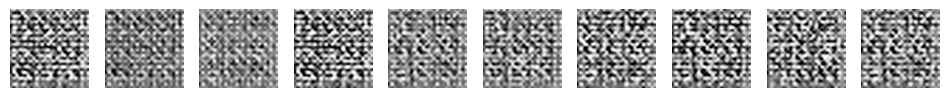

In [45]:
show_images(generate_samples(model, 10, 10))

#### Обучаем модель

In [46]:
trainer(count_of_epoch=10, 
        batch_size=64, 
        dataset=MNIST_train,
        model=model, 
        loss_function=loss_function,
        optimizer=optimizer,
        lr = 2e-4,
        callback = None)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

#### Как генерируются данные после обучения

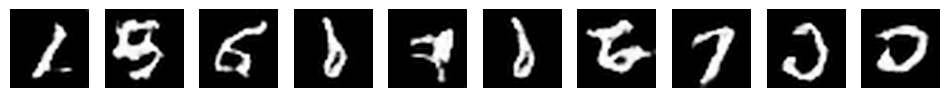

In [47]:
show_images(generate_samples(model, 10, 50))